# Reinforcement Learning Basics


In this notebook we will:

* Introduce the OpenAI Gym library, which is super helpful to understand (and do research in) reinforcement learning in Pytorch.
* Learn how to code up an RL model using policy gradients.


# The OpenAI Gym

Here is a list of environments you can play with.
https://gym.openai.com/envs/

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import gym

## Examples of environments

There is the familiar [Cartpole](https://gym.openai.com/envs/CartPole-v1/) environment...

In [2]:
env = gym.make('CartPole-v1')

In [3]:
print(env.observation_space)
print(env.observation_space.shape)

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
(4,)


In [4]:
print(env.action_space)

Discrete(2)


Below, we will train an RL model using Policy Gradients for this environment.

There are also more complex environments. For example, classic video games from [Atari](http://www.atarimania.com/) can be solved via RL.

In [5]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Air Raid (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Alien.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying crazy_climber.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Crazy Climber.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/crazy_climber.bin
copying elevator_action.bin from HC ROMS/BY ALPHABET (PAL)/

In [6]:
env = gym.make('Freeway-v0')

In [7]:
print(env.observation_space)
print(env.action_space)

Box(0, 255, (210, 160, 3), uint8)
Discrete(3)


In [10]:
env.seed(1234)
state = env.reset()
print(state.shape)

(210, 160, 3)


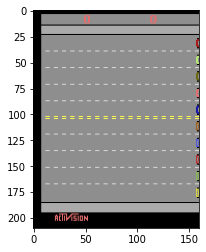

In [11]:
plt.imshow(state)

In [9]:
print(env.unwrapped.get_action_meanings())

['NOOP', 'UP', 'DOWN']


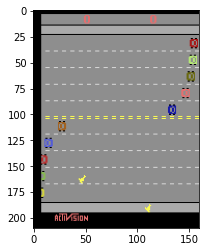

In [17]:
up_action = env.unwrapped.get_action_meanings().index('UP')
state = env.reset()
for i in range(10):
  state, reward, done, info = env.step(up_action)
  plt.imshow(state)

# Policy Gradients

Let's train an RL model using PG. These are called "policy networks".

In [18]:
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

In [30]:
seed = 1234
train_env.seed(seed)
test_env.seed(seed+1)
np.random.seed(seed)
torch.manual_seed(seed)

Our policy network will be a shallow MLP. It will take in as inputs a sequence of states, and learn to produce actions. 

In [31]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super().__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [32]:
input_dim = train_env.observation_space.shape[0]
print(input_dim)

4


In [33]:
output_dim = train_env.action_space.n
print(output_dim)

2


In [34]:
hidden_dim = 128
policy = PolicyNet(input_dim,hidden_dim,output_dim)
print(policy)

PolicyNet(
  (fc_1): Linear(in_features=4, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [35]:
optimizer = optim.Adam(policy.parameters(),lr=0.01)

Let us now set up the core PG method. 

It's a bit more involved than just declaring a loss function and computing `loss.backward()` since at each iteration we will need to sample a bunch of trajectories (rollouts), measure rewards/returns, and use the log-derivative trick.

Let's first calculate expected discounted future rewards (or returns).



In [36]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)    
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

Now let's compute the gradients. Recall [from our notes](https://chinmayhegde.github.io/dl-notes/notes/lecture09/) that this gradient is equal to the expected reward, times the log of the output of the policy network.

In [37]:
def update_policy(returns, log_prob_actions, optimizer):
    
    returns = returns.detach()    
    loss = - (returns * log_prob_actions).sum()

    optimizer.zero_grad()    
    loss.backward()  
    optimizer.step()
    
    return loss.item()

So finally we are ready to write our training procedure.

Some notes to keep in mind:

* our policy network produces a probability distribution over actions. We cannnot simply choose the best action each time; instead, we *sample* from this distribution

* We keep a running track of the log of the probabilities (needed to compute the returns as discussed above).

* Once we choose an action, the environment produces a reward, and moves to the next state. This is achieved by `env.step`. We keep track of the rewards (need to compute the returns as discussed above).

* The `done` variable gets set to one if the episode ends (i.e. the agent either reaches the goal, or gets terminated).


In [38]:
def train(env, policy, optimizer, discount_factor):
    
    policy.train()
    
    log_prob_actions = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)
        action_pred = policy(state)
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)
        action = dist.sample()
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        rewards.append(reward)

        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)
    returns = calculate_returns(rewards, discount_factor)
    loss = update_policy(returns, log_prob_actions, optimizer)

    return loss, episode_reward

On the side, we also write a function to test our learned policy. It's similar to training, except that testing is done by choosing the best action at each time step. Also, there is no need to keep track of log probabilities (since there are no gradients to be calculated).

In [39]:
def evaluate(env, policy):
    
    policy.eval()
    
    done = False
    episode_reward = 0
    state = env.reset()

    while not done:
        
        state = torch.FloatTensor(state).unsqueeze(0)
        
        with torch.no_grad():
        
            action_pred = policy(state)        
            action_prob = F.softmax(action_pred, dim = -1)
                            
        action = torch.argmax(action_prob, dim = -1)          
        state, reward, done, _ = env.step(action.item())
        episode_reward += reward
        
    return episode_reward

That's it. Let's set up some boilerplate code to train our policy network for some number of episodes.

We will exit early if the average reward (measured over some moving window) is better than some threshold.

In [40]:
max_episodes = 500
df = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10

train_rewards = []
test_rewards = []

for episode in range(1, max_episodes+1):
    
    loss, train_reward = train(train_env, policy, optimizer, df)
    test_reward = evaluate(test_env, policy)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:    
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        print(f'Reached reward threshold in {episode} episodes')
        break

| Episode:  10 | Mean Train Rewards:  15.2 | Mean Test Rewards:   9.4 |
| Episode:  20 | Mean Train Rewards:  13.6 | Mean Test Rewards:   9.4 |
| Episode:  30 | Mean Train Rewards:  12.5 | Mean Test Rewards:   9.5 |
| Episode:  40 | Mean Train Rewards:  14.6 | Mean Test Rewards:  10.7 |
| Episode:  50 | Mean Train Rewards:  31.7 | Mean Test Rewards:  28.4 |
| Episode:  60 | Mean Train Rewards:  42.8 | Mean Test Rewards:  43.0 |
| Episode:  70 | Mean Train Rewards:  59.7 | Mean Test Rewards:  89.3 |
| Episode:  80 | Mean Train Rewards:  88.8 | Mean Test Rewards: 168.3 |
| Episode:  90 | Mean Train Rewards: 135.2 | Mean Test Rewards: 303.6 |
| Episode: 100 | Mean Train Rewards: 185.3 | Mean Test Rewards: 356.5 |
| Episode: 110 | Mean Train Rewards: 196.4 | Mean Test Rewards: 327.2 |
| Episode: 120 | Mean Train Rewards: 178.3 | Mean Test Rewards: 261.0 |
| Episode: 130 | Mean Train Rewards: 174.9 | Mean Test Rewards: 256.9 |
| Episode: 140 | Mean Train Rewards: 137.0 | Mean Test Rewards: 

Let's see how we did!

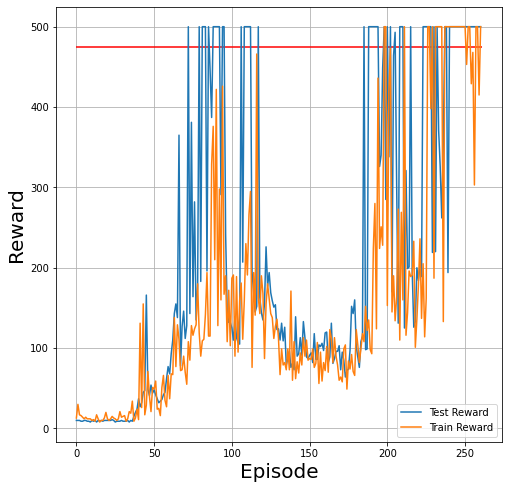

In [42]:
plt.figure(figsize=(8,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()